In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset, prepare_test_dataset, sample_subsequences
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel, initialise_model
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from isaac.training import evaluate, training_loop, evaluate_saved_model
from isaac.sanity import class_proportions

In [4]:
BATCH_SIZE = 128
EPOCHS = 100
TEST_SIZE = 0.2
NORMALISE_DATA = True
STEP_SIZE = 2
SEQ_END = 1800

# Define common model, loss and optimizer

In [5]:
INPUT_DIM = len(BASIC_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 20  # hidden layer dimension
N_LAYERS = 3     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

# MASS TRAINING (Humans achieve 46% +- 29%)

## Read dataset and preprocess it

In [6]:
all_trials = read_dataset("data/train_passive_trials.h5", n_trials=3000)

100%|██████████| 3000/3000 [00:12<00:00, 231.95it/s]


In [7]:
train_loader, val_loader, scaler = prepare_dataset(all_trials, class_columns=MASS_CLASS_COLS, 
                                                   batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA, 
                                                   test_size=TEST_SIZE)

100%|██████████| 3000/3000 [00:02<00:00, 1112.96it/s]


In [8]:
class_proportions(train_loader)
class_proportions(val_loader)

[772 797 831]
Majority class:  0.34625
[199 186 215]
Majority class:  0.35833333333333334


## Define model, loss and optimizer

In [9]:
model, error, optimizer = initialise_model(network_dims, DROPOUT, lr=0.01)

## Train model and plot loss and accuracy

In [10]:
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS,
                                                           seq_end=SEQ_END, step_size=STEP_SIZE)

Train_loss (0.11)	 Train_acc (66.21)	 Val_acc (62.17): 100%|██████████| 100/100 [07:27<00:00,  3.84s/it]


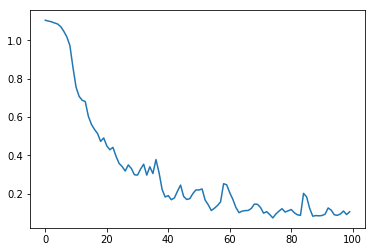

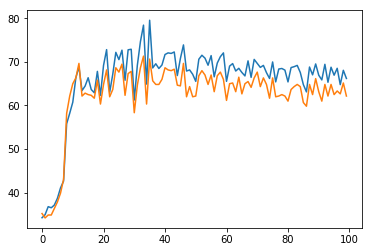

In [11]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [12]:
max(epoch_accuracies[1])

71.33333333333333

## Save model and scaler

In [13]:
torch.save(best_model.state_dict(), "models/passive_mass_model.pt")
joblib.dump(scaler, "scalers/passive_mass_scaler.sk")

['scalers/passive_mass_scaler.sk']

## Load model and evaluate

100%|██████████| 500/500 [00:00<00:00, 1077.09it/s]


Model's accuracy on test set: 47.0


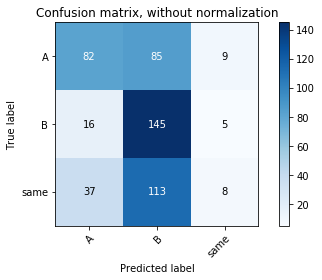

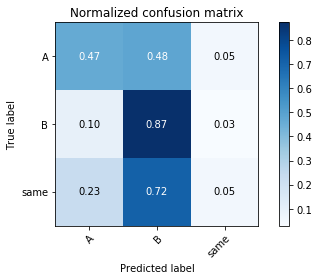

In [6]:
model_path = "models/passive_mass_model.pt"
scaler_path = "scalers/passive_mass_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
test_dataset_path = "data/test_passive_trials.h5"
class_columns = MASS_CLASS_COLS

evaluate_saved_model(model_path, network_dims, test_dataset_path, MASS_CLASS_COLS, step_size=STEP_SIZE, scaler_path=scaler_path)

# FORCE TRAINING  (Humans achieve 61% +- 22%)

## Read dataset and preprocess it

In [7]:
all_trials = read_dataset("data/train_passive_trials.h5", n_trials=3000)
train_loader, val_loader, scaler = prepare_dataset(all_trials, class_columns=FORCE_CLASS_COLS, 
                                                   batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA, 
                                                   test_size=TEST_SIZE)

100%|██████████| 3000/3000 [00:02<00:00, 1084.93it/s]


In [8]:
class_proportions(train_loader)
print()
class_proportions(val_loader)

[812 801 787]
Majority class:  0.3383333333333333

[191 212 197]
Majority class:  0.35333333333333333


## Define model, loss and optimizer

In [9]:
model, error, optimizer = initialise_model(network_dims, DROPOUT, lr=0.01)

## Train model and plot loss and accuracy

In [10]:
model.train()
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS, seq_end=SEQ_END, step_size=STEP_SIZE)

Train_loss (0.07)	 Train_acc (85.75)	 Val_acc (79.33): 100%|██████████| 100/100 [07:54<00:00,  4.48s/it]


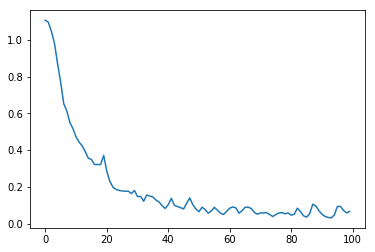

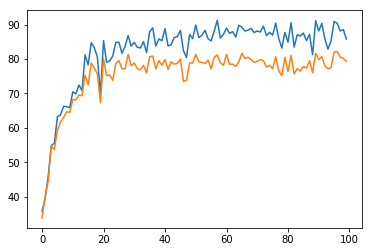

In [11]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [12]:
max(epoch_accuracies[1])

82.16666666666667

## Save model and scaler

In [13]:
torch.save(best_model.state_dict(), "models/passive_force_model.pt")
joblib.dump(scaler, "scalers/passive_force_scaler.sk")

['scalers/passive_force_scaler.sk']

## Evaluate saved model

100%|██████████| 500/500 [00:00<00:00, 959.32it/s]


Model's accuracy on test set: 59.0


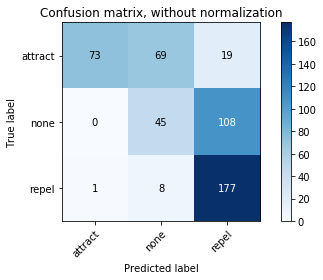

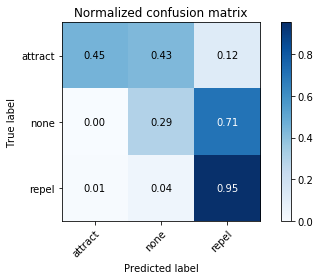

In [14]:
model_path = "models/passive_force_model.pt"
scaler_path = "scalers/passive_force_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
test_dataset_path = "data/test_passive_trials.h5"
class_columns = FORCE_CLASS_COLS

evaluate_saved_model(model_path, network_dims, test_dataset_path, FORCE_CLASS_COLS, step_size=STEP_SIZE, scaler_path=scaler_path)